In [1]:
import sys, torch
import torch.nn.functional as F
import numpy as np

module_rootdir = '.'
dataset_rootdir = '.'
label_rootdir = module_rootdir
sys.path.append(module_rootdir)

trained_proposal_weights_path = './model_weights/gnn/1715232829109/graph_based_detector.pt'
proposal_config_file_path = './configuration_radarscenes_gnn.yml'
classifier_config_file_path = './configuration_radarscenes_classifier.yml'

from modules.set_configurations.common import read_yaml
from modules.set_configurations.set_config_gnn import config as config_gnn
from modules.set_configurations.set_config_classifier import config as config_classifier
from modules.set_configurations.set_param_for_inference_gnn import set_parameters_for_inference
from modules.neural_net.classifier.classifier import Model_Training
from modules.inference.clustering import Simple_DBSCAN
from modules.data_utils.read_data import get_sequence_data
from modules.data_utils.labels import compute_new_labels_to_id_dict
from modules.data_utils.labels import compute_old_to_new_label_id_map

from modules.data_generator.datagen_gnn import compute_node_idx_for_each_cluster
from modules.data_utils.read_data import extract_frame
from modules.compute_groundtruth.compute_node_labels import compute_ground_truth as compute_ground_truth_node
from modules.compute_features.graph_features import select_moving_data
from modules.compute_features.graph_features import compute_adjacency_information
from modules.compute_features.graph_features import compute_edge_features
from modules.compute_features.graph_features import compute_node_features
from modules.compute_groundtruth.compute_offsets import unnormalize_gt_offsets
from modules.data_generator.datagen_classifier import extract_proposals
from modules.data_generator.datagen_classifier import extract_and_compute_features_and_labels
from modules.data_generator.datagen_classifier import remove_low_quality_proposals
from modules.data_generator.datagen_classifier import compute_graph

from modules.compute_groundtruth.compute_node_labels import compute_gt_clusters
from modules.inference.ellipse import compute_cov_ellipse
from modules.plot_utils.plot_func import compare_pred_gt_clusters

sequence_name = 'sequence_148' # 'sequence_108'  # 'sequence_148'

In [2]:
config_gnn_obj = config_gnn(proposal_config_file_path)
config_classifier_obj = config_classifier(proposal_config_file_path, classifier_config_file_path)

param_obj = set_parameters_for_inference(module_rootdir, config_gnn_obj, trained_proposal_weights_path)
device = param_obj['device']
grid = param_obj['grid']
prop_extractor = param_obj['detector']

detector_train = Model_Training(config_classifier_obj)
detector_train = detector_train.to(device)

params = [p for p in detector_train.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, momentum=0.9, lr=config_classifier_obj.learning_rate, weight_decay=config_classifier_obj.weight_decay)

clustering_eps = config_classifier_obj.clustering_eps # 1.4
valid_cluster_num_meas_thr = config_classifier_obj.valid_cluster_num_meas_thr  # 2
meas_noise_cov = config_classifier_obj.meas_noise_cov
clustering_obj = Simple_DBSCAN(clustering_eps)

scene_metadata, radar_mount_data, radar_data_all_scenes, odometry_data_all_scenes \
    = get_sequence_data(dataset_rootdir, config_classifier_obj.dataset_path, sequence_name, config_classifier_obj.window_size)

labels_to_id_dict = compute_new_labels_to_id_dict()
old_to_new_label_id_map = compute_old_to_new_label_id_map()

GPU is available. Good to go!


----------------------------------------------------------------------------------------------------
frame number: 40


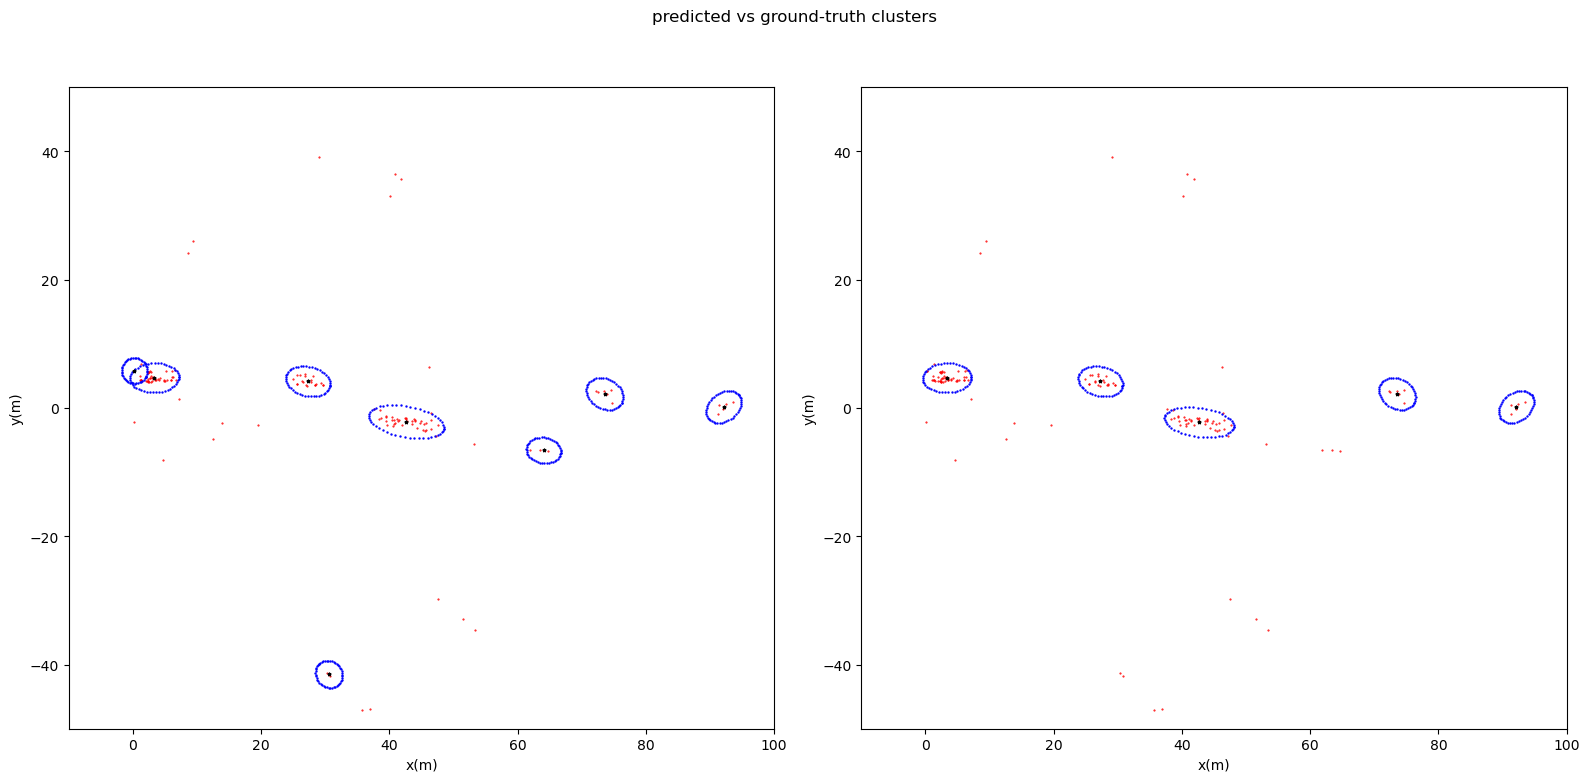

In [3]:
def process_frame(idx):

    print('-' * 100)
    print(f'frame number: {idx}')

    data_dict = extract_frame(
        idx = idx, 
        windowed_data_list = scene_metadata,
        radar_mount_data = radar_mount_data,
        radar_data_all_scenes = radar_data_all_scenes,
        odometry_data_all_scenes = odometry_data_all_scenes,
        reject_outlier = False)
    
    gt_dict_node = compute_ground_truth_node(data_dict, labels_to_id_dict, old_to_new_label_id_map)
    data_dict, gt_dict_node = grid.select_meas_within_the_grid(data_dict, gt_dict_node)
    data_dict_dyn, node_labels_dict_dyn = select_moving_data(data_dict, gt_dict_node, labels_to_id_dict)
    adj_dict_dyn = compute_adjacency_information(
        data_dict_dyn, config_classifier_obj.ball_query_eps_square, config_classifier_obj.k_number_nearest_points)

    other_features_dyn = np.stack((
            data_dict_dyn['meas_px'], data_dict_dyn['meas_py'], 
            data_dict_dyn['meas_vx'], data_dict_dyn['meas_vy']), axis=-1)
    edge_features_dyn = compute_edge_features(data_dict_dyn, adj_dict_dyn['adj_list'])
    node_features_dyn = compute_node_features(
            data_dict_dyn, adj_dict_dyn['degree'], 
            include_region_confidence = config_classifier_obj.include_region_confidence, 
            min_range = config_classifier_obj.grid_min_r, max_range = config_classifier_obj.grid_max_r, 
            min_azimuth = config_classifier_obj.grid_min_th, max_azimuth = config_classifier_obj.grid_max_th)
    
    graph_features = {}
    graph_features['other_features_dyn'] = torch.from_numpy(other_features_dyn).to(device).to(torch.float32)
    graph_features['edge_features_dyn'] = torch.from_numpy(edge_features_dyn).to(device).to(torch.float32)
    graph_features['node_features_dyn'] = torch.from_numpy(node_features_dyn).to(device).to(torch.float32)
    graph_features['edge_index_dyn'] = torch.from_numpy(adj_dict_dyn['adj_list'] ).to(device).to(torch.int64)
    graph_features['adj_matrix_dyn'] = torch.from_numpy(adj_dict_dyn['adj_matrix'] ).to(device).to(torch.bool)

    gt_labels_dyn = node_labels_dict_dyn['class_labels']
    cluster_node_idx, cluster_labels = compute_node_idx_for_each_cluster(data_dict_dyn['meas_trackid'], gt_labels_dyn, device)

    # cluster offsets predictions
    _, node_offsets_predictions, _, _ = prop_extractor(
            node_features = graph_features['node_features_dyn'],
            edge_features = graph_features['edge_features_dyn'],
            edge_index = graph_features['edge_index_dyn'],
            adj_matrix = graph_features['adj_matrix_dyn'],
            cluster_node_idx = cluster_node_idx )
    
    reg_deltas = unnormalize_gt_offsets(node_offsets_predictions, config_classifier_obj.reg_mu, config_classifier_obj.reg_sigma)
    pred_cluster_centers_xy = graph_features['other_features_dyn'][:, :2] + reg_deltas

    # extract proposals
    pred_cluster_centers_xy = pred_cluster_centers_xy.detach().cpu().numpy()
    proposal_list = extract_proposals(pred_cluster_centers_xy, clustering_obj)

    # compute aggregate features and compute labels for each proposal
    px = graph_features['other_features_dyn'][:, 0].detach().cpu().numpy()
    py = graph_features['other_features_dyn'][:, 1].detach().cpu().numpy()
    rcs = graph_features['node_features_dyn'][:, 1].detach().cpu().numpy()

    object_features_list, object_class_list, \
    object_mu_list, object_sigma_list, object_num_meas_list \
        = extract_and_compute_features_and_labels(
                proposal_list, px, py, rcs, 
                node_labels_dict_dyn['class_labels'], 
                meas_noise_cov)
            
    # remove bad quality proposals
    # a proposal is considered bad quality of num_meas of each clustered proposal < self.num_meas_thr
    object_features_list, object_class_list, \
    pred_mu_list, pred_sigma_list, object_num_meas_list \
        = remove_low_quality_proposals(
            valid_cluster_num_meas_thr, object_features_list, object_class_list, 
            object_mu_list, object_sigma_list, object_num_meas_list)
    
    # ======================================================================================
    # compare prediction vs ground-truth clusters
    gt_mu_list, gt_sigma_list = compute_gt_clusters(px, py, data_dict_dyn['meas_trackid'], meas_noise_cov)
    gt_cluster_boundary_points_list = []
    for mu, cov in zip(gt_mu_list, gt_sigma_list):
        boundary_points, _ = compute_cov_ellipse(mu, cov, chi_sq = 2, n_points=50)
        gt_cluster_boundary_points_list.append(boundary_points)

    pred_cluster_boundary_points_list = []
    for mu, cov in zip(pred_mu_list, pred_sigma_list):
        boundary_points, _ = compute_cov_ellipse(mu, cov, chi_sq = 2, n_points=50)
        pred_cluster_boundary_points_list.append(boundary_points)
    
    compare_pred_gt_clusters(
        px, py, 
        pred_mu_list, pred_cluster_boundary_points_list,
        gt_mu_list, gt_cluster_boundary_points_list,
        boundary_marker_size=2,
        figsize=(16,8))
    # ======================================================================================
    
    # create training data: node_features, graph_structure, cluster_sizes
    object_features, object_class, object_num_meas, edge_idx = \
        compute_graph(object_features_list, object_class_list, object_num_meas_list, device)
    
    training_data = {}
    training_data['object_features'] = [object_features]
    training_data['object_class'] = [object_class]
    training_data['object_num_meas'] = [object_num_meas]
    training_data['edge_idx'] = [edge_idx]

    return training_data


batch_data = process_frame(idx=40)

In [4]:
max_iters = 2000
iter_start_offset = 0

for iter_train_outer in range(iter_start_offset, max_iters):
    detector_train.train()
    loss = detector_train(
        node_features = batch_data['object_features'],
        edge_index = batch_data['edge_idx'],
        object_size = batch_data['object_num_meas'],
        groundtruths = batch_data['object_class'] )

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    loss_str = f"[Iter {iter_train_outer}][Class loss: {loss.item():.15f}]"
    print(loss_str)

[Iter 0][Class loss: 4.499345302581787]
[Iter 1][Class loss: 4.339859008789062]
[Iter 2][Class loss: 4.027580261230469]
[Iter 3][Class loss: 3.337669849395752]
[Iter 4][Class loss: 1.263587474822998]
[Iter 5][Class loss: 8.526643753051758]
[Iter 6][Class loss: 3.869756221771240]
[Iter 7][Class loss: 4.299895286560059]
[Iter 8][Class loss: 4.382486343383789]
[Iter 9][Class loss: 4.413622856140137]
[Iter 10][Class loss: 4.427082538604736]
[Iter 11][Class loss: 4.428927421569824]
[Iter 12][Class loss: 4.418644428253174]
[Iter 13][Class loss: 4.392259597778320]
[Iter 14][Class loss: 4.345764160156250]
[Iter 15][Class loss: 4.264877796173096]
[Iter 16][Class loss: 4.116000175476074]
[Iter 17][Class loss: 3.804168224334717]
[Iter 18][Class loss: 3.003735303878784]
[Iter 19][Class loss: 1.130524754524231]
[Iter 20][Class loss: 4.706548213958740]
[Iter 21][Class loss: 3.815249204635620]
[Iter 22][Class loss: 4.358558654785156]
[Iter 23][Class loss: 4.427595138549805]
[Iter 24][Class loss: 4.44

In [5]:
@ torch.no_grad()
def inference(classifier):
    pred_class_logits = classifier(
        node_features = batch_data['object_features'][0],
        edge_index = batch_data['edge_idx'][0],
        object_size = batch_data['object_num_meas'][0])
    cls_prob = F.softmax(pred_class_logits, dim=-1)
    cls_score, cls_idx = torch.max(cls_prob, dim=-1)
    return cls_score, cls_idx

classifier = detector_train.pred.eval()
cls_score, cls_idx = inference(classifier)

print(f"predicted class scores: {cls_score}")
print(f"predicted class       : {cls_idx}")
print(f"ground-truth classses : {batch_data['object_class'][0]}")

predicted class scores: tensor([1.0000, 0.9980, 1.0000, 1.0000, 0.9982, 0.9988, 0.9987, 0.9987],
       device='cuda:0')
predicted class       : tensor([0, 0, 0, 0, 4, 6, 6, 6], device='cuda:0')
ground-truth classses : tensor([0, 0, 0, 0, 4, 6, 6, 6], device='cuda:0')
